In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def keep_cleaning(on, off, threshold=2.0, verbose=False):
    """Compute residuals from data after clean component subtraction. 
    The rms and baseline is determined from the "offpulse" time series, 
    and the signal strength is calculated from the "onpulse" region.
    """
    rms = np.std(off)
    #median = np.median(off) # median is more reliable than mean
    mean = np.mean(off)
    
    datamax = np.max(on)

    #limit = median + threshold * rms
    limit = mean + threshold * rms
    
    if datamax > limit:
        #if verbose:
        #    print("Onpulse data maximum still above threshold")
        #    print("{0:g} > {1:g}".format(datamax, limit))
        return True
    else:
        if verbose:
            print("No more data are above the given threshold ({0}-sigma)".format(threshold))
            print("    data max.={0}".format(datamax))
            print("    threshold={0}".format(threshold * rms))
        return False

In [3]:
def gaussian(x, mu, sigma):
    gaus = (1 / (np.sqrt(2) * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return gaus / gaus.max()

In [4]:
def pbf1(x, x0, tau):
    h = (1 / tau) * np.exp(-(x-x0)/tau)
    h[x <= x0] = 0
    
    return h

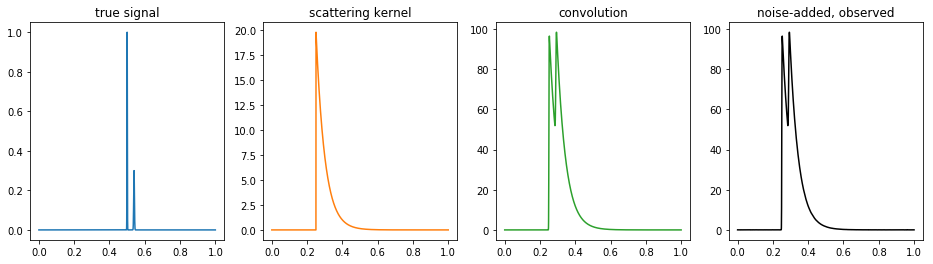

peak intensity=98.3716909317
rms=0.344036928991
snr=285.93352237
on-pulse range=490:1000
No more data are above the given threshold (3-sigma)
    data max.=0.0293044082639
    threshold=0.029553056867


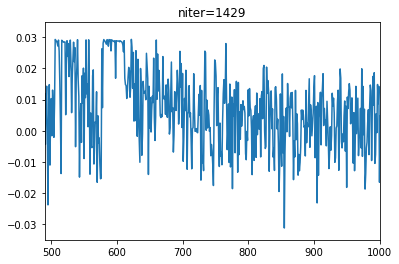

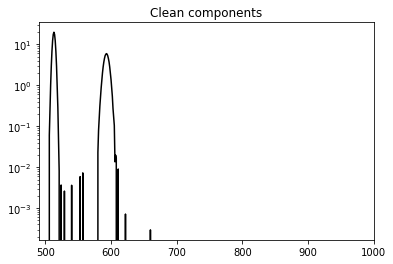

(array([506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
       519, 520, 521, 524, 529, 540, 553, 557, 580, 581, 582, 583, 584,
       585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
       598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 611, 622, 660]),)
number of unique clean components created=53
total clean components added=1429
model offet=510
mean res. = -0.000221301178806
rms res. = 0.00985101895566
3.2066498579


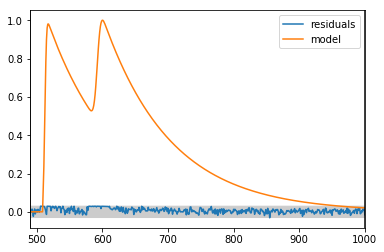

(-0.6745904839604151, 0.39619568344646439)


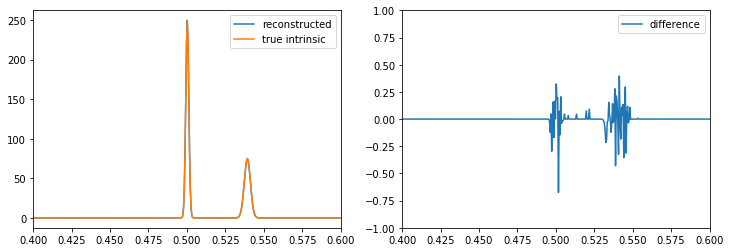

(0.0040106052394096002, 0.079416331911493943, 0.050501013366863204)


In [29]:
## Test deconvolution process
np.random.seed(11111)
x = np.linspace(0, 1, 2048)
x0 = x[x.size//4]

f = np.zeros_like(x)
f += gaussian(x, x[f.size//2], 0.001)
f += 0.3 * gaussian(x, x[f.size//2+80], 0.002)
#f[f.size//2] = 1.0
#f[f.size//2+600] = 0.5
int_f = simps(y=f, x=x)

response = np.zeros_like(f)
response[response.size//2] = 1.0 # i.e. assume response is a delta function

tau = 0.05
h = pbf1(x, x0, tau)

g = np.convolve(f, h, mode="full")
g = np.roll(g[g.size//4:3*g.size//4], -1)



# Initialise counters and boolean checks
loop = True
niter = 0

# Create an empty array of shape and type of data to store clean components
data = np.copy(g) + np.random.normal(0, 0.01, g.size)
data_init = np.copy(data)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=plt.figaspect(0.25))
ax1.plot(x, f, color="C0")
ax2.plot(x, h, color="C1")
ax3.plot(x, g, color="C2")
ax4.plot(x, data, color="k")
ax1.set_title("true signal")
ax2.set_title("scattering kernel")
ax3.set_title("convolution")
ax4.set_title("noise-added, observed")
plt.show()



nbins = len(data_init)
clean_components = np.zeros_like(data)
gain = 0.01
filter_guess = pbf1(x, x0, tau)

on_lims = (490, 1000)
offpulse = np.concatenate((data[:on_lims[0]], data[on_lims[1]:]))
init_rms = np.std(offpulse)

onpulse = data[on_lims[0]:on_lims[1]]

#plt.plot(offpulse)
#plt.show()

#plt.plot(data)
#plt.axvline(on_lims[0])
#plt.axvline(on_lims[1])


print("peak intensity={0}".format(onpulse.max()))
print("rms={0}".format(init_rms))
print("snr={0}".format(onpulse.max()/init_rms))
thresh = 3
print("on-pulse range={0}:{1}".format(on_lims[0], on_lims[1]))

while loop:
    
    imax = np.argmax(data[on_lims[0]:on_lims[1]]) + on_lims[0]
    dmax = data[imax]
    
    niter += 1
    
    temp_clean_comp = np.zeros_like(clean_components)
    temp_clean_comp[imax] = dmax * gain
    clean_components[imax] += dmax * gain
    
    rest_func = np.convolve(temp_clean_comp, response, mode="same")
    rest_func = np.convolve(rest_func, filter_guess, mode="same")
    rest_func = rest_func / np.max(rest_func)
    
    component = rest_func * temp_clean_comp[imax]
    offset = np.argmax(temp_clean_comp) - np.argmax(rest_func)
    component = np.roll(component, offset)
    
    cleaned = data - component
    
    onpulse = cleaned[on_lims[0]:on_lims[1]]
    offpulse = np.concatenate((cleaned[:on_lims[0]], cleaned[on_lims[1]:]))
    
    loop = keep_cleaning(onpulse, offpulse, threshold=thresh, verbose=True)
    
    #plt.plot(cleaned)
    #plt.plot(component, color="r")
    data = np.copy(cleaned)
    
    
plt.plot(cleaned)
plt.title("niter={0}".format(niter))
plt.xlim(on_lims)
plt.show()

plt.plot(clean_components, color="k")
plt.yscale("log", clip=True)
plt.xlim(on_lims)
plt.title("Clean components")
plt.show()

print(np.nonzero(clean_components))
print("number of unique clean components created={0}".format(np.count_nonzero(clean_components)))
print("total clean components added={0}".format(niter))

model = np.convolve(clean_components, h, mode="same")
model_offset = abs(np.argmax(model) - np.argmax(data_init))
print("model offet={0}".format(model_offset))
model = np.roll(model, model_offset)
    
#residuals = data_init - model
residuals = cleaned

offpulse = np.concatenate((residuals[:on_lims[0]], residuals[on_lims[1]:]))
mean_offpulse = np.mean(offpulse)
rms_offpulse = np.std(offpulse)
print("mean res. = {0}".format(mean_offpulse))
print("rms res. = {0}".format(rms_offpulse))
upper = mean_offpulse + thresh*rms_offpulse
lower = mean_offpulse - thresh*rms_offpulse

print(residuals.max() / rms_offpulse)

    
#plt.plot(data_init, label="data")
plt.plot(residuals, label="residuals")
plt.plot(model/model.max(), label="model")
plt.fill_between(np.linspace(0, len(model)-1, len(model)), lower, upper, color="0.8")
plt.axvline(on_lims[0], color="k")
plt.axvline(on_lims[1], color="k")
#plt.ylim(-0.05, 0.1)
plt.xlim(on_lims)
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=plt.figaspect(0.33))
recon = np.convolve(clean_components, response, mode="same")
recon_offset = abs(np.argmax(recon) - np.argmax(response))
recon = np.roll(recon, recon_offset)
int_r = simps(y=recon, x=x)
norm_r = recon/int_r
norm_f = f/int_f
safe_norm_f = np.copy(norm_f)
safe_norm_f[norm_f == 0] = np.nan
frac_diff = (norm_r - norm_f) # / safe_norm_f
print(np.nanmin(frac_diff), np.nanmax(frac_diff))
ax1.plot(x, norm_r, label="reconstructed")
ax1.plot(x, norm_f, label="true intrinsic")
ax2.plot(x, frac_diff, label="difference")


for ax in fig.axes:
    ax.set_xlim(0.4,0.6)
    ax.legend()
ax2.set_ylim(-1, 1)
plt.show()

print(int_f, int_r, int_f/int_r)